<a href="https://colab.research.google.com/github/ab2gbl/ECG-detection/blob/main/U_Net_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!mkdir /content/physionet.org/
!mkdir /content/physionet.org/files/
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org/files/ludb' '/content/physionet.org/files/'
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org/files/qtdb' '/content/physionet.org/files/'

mkdir: cannot create directory ‘/content/physionet.org/’: File exists
mkdir: cannot create directory ‘/content/physionet.org/files/’: File exists


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install wfdb
!pip install keras-tuner --quiet
!pip install resnet1d
!pip install tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 108.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.8 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement resnet1d (from versions: none)
ERROR: No matching distribution found for resnet1d


# preprocess

In [6]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
from re import S
import os

In [7]:
def bandpass_filter(signal, lowcut=0.5, highcut=10, fs=250, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed
def normalize_signal(data):
    """
    Normalize the signal using z-score normalization.
    """
    return (data - np.mean(data)) / np.std(data)

In [8]:

from scipy.signal import resample

def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal
def adjust_annotations(samples, original_fs, target_fs):
    """
    Rescales annotation sample indices from original_fs to target_fs.
    Works with scalars or lists/arrays.
    """
    scale = target_fs / original_fs
    if isinstance(samples, (list, np.ndarray)):
        return (np.array(samples) * scale).astype(int)
    else:
        return int(samples * scale)



In [9]:


def extract_wave_regions(samples, symbols, fs, extra_ms={'p':0,'N':20,'t':0}):
    wave_regions = {'p': [], 'N': [], 't': []}
    start = None
    qrs_symbols = ['N', 'L', 'R', 'V', 'A']
    current_symbol = None
    a = fs/ 1000
    for i in range(len(symbols)):

        if symbols[i] == '(':
            start = samples[i]
            current_symbol = None
        elif symbols[i] in wave_regions:

            current_symbol = symbols[i]
        elif symbols[i] in qrs_symbols:
            current_symbol = 'N'
        elif symbols[i] == ')' and current_symbol:
            end = samples[i]
            if start and end and current_symbol:
              #print(extra_ms['p'])
              wave_regions[current_symbol].append((int(start-extra_ms[current_symbol]*a), int(end+extra_ms[current_symbol]*a)))

            start = None
            current_symbol = None
    return wave_regions


In [10]:
def create_multi_class_mask(length, wave_regions):

    mask = np.zeros((length, 4))  # [BG, P, QRS, T]
    label_map = {'p': 1, 'N': 2, 't': 3}
    for label, regions in wave_regions.items():
        for start, end in regions:
            start = max(0, start)
            end = min(length, end)
            mask[start:end, label_map[label]] = 1

    mask[:, 0] = (mask[:, 1:] == 0).all(axis=1).astype(float)
    return mask

In [11]:
def segment_signal_and_mask(signal, mask, window_size, stride):
    segments, masks = [], []
    for i in range(0, len(signal) - window_size + 1, stride):
        segment = signal[i:i + window_size]
        mask_segment = mask[i:i + window_size]
        if len(segment) == window_size and len(mask_segment) == window_size:
            segments.append(segment)
            masks.append(mask_segment)
    return np.array(segments), np.array(masks)


In [12]:
def process_record(record_path, Type='LUDB', extra_ms={'p':0,'N':20,'t':0}, target_fs=250, window_sec=1.0):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]  # lead I
    fs = record.fs
    if Type == 'QTDB':
        annotations = wfdb.rdann(record_path, 'pu0')
    else:
        annotations = wfdb.rdann(record_path, 'i')
    samples = annotations.sample
    symbols = annotations.symbol

    # Preprocessing
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    if fs != target_fs:
        signal = resample_signal(signal, original_fs=fs, target_fs=target_fs)
        samples = adjust_annotations(samples, original_fs=fs, target_fs=target_fs)
        fs = target_fs

    #print("done")
    # Wave region labeling
    wave_regions = extract_wave_regions(samples, symbols, fs, extra_ms=extra_ms)
    #print(wave_regions['t'])
    mask = create_multi_class_mask(len(signal), wave_regions)

    # Segment
    window_size = int(240)
    stride = window_size // 5  # 80% overlap
    segments, masks = segment_signal_and_mask(signal, mask, window_size, stride)

    # Final shape fix
    segments = np.expand_dims(segments, axis=1)  # (N, 1, L)
    masks = np.argmax(masks, axis=-1)            # (N, L)
    return segments, masks



In [13]:
def get_all_records(directory, extension=".dat"):
    files = [f.replace(extension, "") for f in os.listdir(directory) if f.endswith(extension)]
    return list(set(files))  # Ensure no duplicates

# Set paths for QTDB and LUDB
qtdb_path = "/content/physionet.org/files/qtdb/1.0.0/"
ludb_path = "/content/physionet.org/files/ludb/1.0.1/data/"

# Get all record names dynamically
qt_records = get_all_records(qtdb_path)
lu_records = get_all_records(ludb_path)

print(f"Found {len(qt_records)} QTDB records and {len(lu_records)} LUDB records.")

Found 105 QTDB records and 200 LUDB records.


In [14]:
qt_segments_list, qt_masks_list = [], []

for record_path in qt_records[:-1]:
    try:
        print(f"Processing {record_path}")
        segments, masks = process_record(qtdb_path+record_path, Type='QTDB', extra_ms={'p':0,'N':20,'t':0},target_fs=250)  # Resample to 250 Hz
        qt_segments_list.append(segments)
        qt_masks_list.append(masks)
    except:
        print(f"Skipping {record_path} due to error.")

Processing sele0405
Processing sel17152
Processing sel34
Processing sel44
Processing sele0409
Processing sele0509
Processing sele0126
Processing sel811
Processing sele0704
Processing sele0122
Processing sele0607
Processing sel233
Processing sel230
Processing sel42
Processing sel821
Processing sele0609
Processing sel232
Processing sele0612
Processing sele0104
Processing sel853
Processing sel15814
Processing sel16539
Processing sel38
Processing sel301
Processing sel46
Processing sele0106
Processing sele0121
Processing sel310
Processing sele0170
Processing sel231
Processing sel39
Processing sel221
Processing sel116
Processing sel114
Processing sel16420
Processing sel30
Processing sel820
Processing sel14046
Processing sel43
Processing sel100
Processing sel872
Processing sele0112
Processing sel306
Processing sel808
Processing sel16483
Processing sel302
Processing sel803
Processing sel223
Processing sel41
Processing sel16795
Processing sel40
Processing sel104
Processing sele0210
Processing s

In [15]:

lu_segments_list, lu_masks_list = [], []
for record_path in lu_records:
    try:
        print(f"Processing {record_path}")
        segments, masks = process_record(ludb_path+record_path, Type='LUDB', extra_ms={'p':0,'N':20,'t':0},target_fs=250)  # Resample to 250 Hz

        lu_segments_list.append(segments)
        lu_masks_list.append(masks)
    except:
        print(f"Skipping {record_path} due to error.")

Processing 145
Processing 56
Processing 135
Processing 66
Processing 139
Processing 109
Processing 166
Processing 85
Processing 1
Processing 138
Processing 190
Processing 164
Processing 18
Processing 47
Processing 140
Processing 161
Processing 153
Processing 30
Processing 176
Processing 98
Processing 121
Processing 200
Processing 123
Processing 162
Processing 196
Processing 128
Processing 119
Processing 173
Processing 60
Processing 51
Processing 182
Processing 24
Processing 174
Processing 101
Processing 9
Processing 31
Processing 23
Processing 87
Processing 54
Processing 111
Processing 95
Processing 72
Processing 170
Processing 183
Processing 53
Processing 130
Processing 148
Processing 181
Processing 194
Processing 114
Processing 125
Processing 79
Processing 38
Processing 167
Processing 102
Processing 35
Processing 96
Processing 188
Processing 137
Processing 165
Processing 63
Processing 28
Processing 15
Processing 187
Processing 27
Processing 189
Processing 76
Processing 89
Processing 

In [16]:
qt_segments = np.concatenate(qt_segments_list, axis=0)
qt_masks = np.concatenate(qt_masks_list, axis=0)
lu_segments = np.concatenate(lu_segments_list, axis=0)
lu_masks = np.concatenate(lu_masks_list, axis=0)

In [17]:
# Combine into final dataset
X = np.concatenate([qt_segments, lu_segments])

qt_segments = None
lu_segments = None
qt_segments_list = None
lu_segments_list = None

In [18]:

y = np.concatenate([qt_masks, lu_masks])

In [19]:
qt_masks = None
lu_masks = None
qt_masks_list = None
lu_masks_list = None

# split dataset

In [20]:
# Create train/test sets (e.g., 80/20 split)
from sklearn.model_selection import train_test_split

# First split 80% train, 20% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Then split 50/50 on temp → 10% val, 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [21]:
from torch.utils.data import Dataset, DataLoader

class ECGWaveformDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.Y[idx], dtype=torch.long)

train_dataset = ECGWaveformDataset(X_train, y_train)
val_dataset = ECGWaveformDataset(X_val, y_val)
test_dataset = ECGWaveformDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)



In [22]:
X=None
y=None

# model and training

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock1D, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

def center_crop(enc_feat, target_size):
    _, _, L = enc_feat.size()
    diff = L - target_size
    if diff == 0:
        return enc_feat
    elif diff < 0:
        raise ValueError("Encoder feature shorter than target")
    start = diff // 2
    end = start + target_size
    return enc_feat[:, :, start:end]

class UNet1D(nn.Module):
    def __init__(self, in_channels=1, n_classes=4, base_filters=64):
        super(UNet1D, self).__init__()
        self.enc1 = ConvBlock1D(in_channels, base_filters)
        self.pool1 = nn.MaxPool1d(2)

        self.enc2 = ConvBlock1D(base_filters, base_filters * 2)
        self.pool2 = nn.MaxPool1d(2)

        self.enc3 = ConvBlock1D(base_filters * 2, base_filters * 4)
        self.pool3 = nn.MaxPool1d(2)

        self.enc4 = ConvBlock1D(base_filters * 4, base_filters * 8)
        self.pool4 = nn.MaxPool1d(2)

        self.bottleneck = ConvBlock1D(base_filters * 8, base_filters * 16)

        self.upconv4 = nn.ConvTranspose1d(base_filters * 16, base_filters * 8, kernel_size=2, stride=2)
        self.dec4 = ConvBlock1D(base_filters * 16, base_filters * 8)

        self.upconv3 = nn.ConvTranspose1d(base_filters * 8, base_filters * 4, kernel_size=2, stride=2)
        self.dec3 = ConvBlock1D(base_filters * 8, base_filters * 4)

        self.upconv2 = nn.ConvTranspose1d(base_filters * 4, base_filters * 2, kernel_size=2, stride=2)
        self.dec2 = ConvBlock1D(base_filters * 4, base_filters * 2)

        self.upconv1 = nn.ConvTranspose1d(base_filters * 2, base_filters, kernel_size=2, stride=2)
        self.dec1 = ConvBlock1D(base_filters * 2, base_filters)

        self.final_conv = nn.Conv1d(base_filters, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder with cropping
        d4 = self.upconv4(b)
        e4 = center_crop(e4, d4.shape[-1])
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.upconv3(d4)
        e3 = center_crop(e3, d3.shape[-1])
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.upconv2(d3)
        e2 = center_crop(e2, d2.shape[-1])
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.upconv1(d2)
        e1 = center_crop(e1, d1.shape[-1])
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.final_conv(d1)  # Output shape: (B, n_classes, L)


In [24]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet1D(n_classes=4)  # background, P, QRS, T
x = torch.randn(8, 1, 256)   # batch of ECG segments
out = model(x)
print(out.shape)  # → (8, 4, 256)

criterion = nn.CrossEntropyLoss()  # For segmentation with class indices

optimizer = optim.Adam(model.parameters(), lr=1e-3)


torch.Size([8, 4, 256])


In [25]:
from tqdm import tqdm

# Compute pixel-wise (point-wise) accuracy
def compute_accuracy(outputs, targets):
    # outputs: (B, C, L), targets: (B, L)
    preds = torch.argmax(outputs, dim=1)  # (B, L)
    correct = (preds == targets).float()
    accuracy = correct.sum() / correct.numel()
    return accuracy.item()

def train(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        train_bar = tqdm(train_loader, desc=f"🧪 Epoch {epoch+1}/{epochs} [Training]", leave=False)

        for X_batch, y_batch in train_bar:
            X_batch = X_batch.to(device)  # (B, 1, L) — good!
            y_batch = y_batch.to(device)  # (B, L)

            optimizer.zero_grad()
            output = model(X_batch)  # (B, C, L)
            loss = criterion(output, y_batch)
            acc = compute_accuracy(output, y_batch)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += acc

            train_bar.set_postfix(loss=loss.item(), acc=f"{acc*100:.2f}%")

        val_loss, val_acc = evaluate(model, val_loader, criterion)

        print(f"📘 Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_acc/len(train_loader)*100:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

def evaluate(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0

    with torch.no_grad():
        val_bar = tqdm(val_loader, desc="🔍 Validating", leave=False)
        for X_batch, y_batch in val_bar:
            X_batch = X_batch.to(device)  # (B, 1, L) — good!
            y_batch = y_batch.to(device)  # (B, L)


            output = model(X_batch)
            loss = criterion(output, y_batch)
            acc = compute_accuracy(output, y_batch)

            total_loss += loss.item()
            total_acc += acc

            val_bar.set_postfix(val_loss=loss.item(), acc=f"{acc*100:.2f}%")

    return total_loss / len(val_loader), total_acc / len(val_loader)


In [27]:
train(model, train_loader, val_loader, criterion, optimizer, epochs=2)

📘 Epoch 1/2 | Train Loss: 0.2150 | Train Acc: 91.57% | Val Loss: 0.1877 | Val Acc: 92.58%


📘 Epoch 2/2 | Train Loss: 0.1751 | Train Acc: 93.07% | Val Loss: 0.1679 | Val Acc: 93.31%


In [28]:
import matplotlib.pyplot as plt
import numpy as np

def test(model, test_loader):
    model.eval()

    test_acc = 0.0

    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(test_loader):
            X_batch = X_batch.to(device)  # shape: (1, 1, L)

            # Handle label shape
            if y_batch.dim() == 3 and y_batch.shape[-1] > 1:
                y_batch = y_batch.argmax(dim=2)
            y_batch = y_batch.to(device)  # shape: (1, L)

            output = model(X_batch)       # shape: (1, C, L)
            preds = torch.argmax(output, dim=1)  # shape: (1, L)

            acc = (preds == y_batch).float().mean()
            test_acc += acc.item()

            # === Visualization ===
            if i == 0:  # plot first sample
                signal = X_batch[0, 0].cpu().numpy()
                pred_mask = preds[0].cpu().numpy()
                true_mask = y_batch[0].cpu().numpy()
                time = np.arange(len(signal))

                plt.figure(figsize=(15, 6))
                plt.plot(time, signal, color='black', label='ECG Signal')

                # Plot predictions
                for class_idx, color, label in zip([1, 2, 3], ['blue', 'red', 'green'], ['P', 'QRS', 'T']):
                    plt.fill_between(time, -1, 1, where=pred_mask == class_idx, color=color, alpha=0.3, label=f'Predicted {label}')
                    plt.fill_between(time, -1, 1, where=true_mask == class_idx, color=color, alpha=0.1, label=f'True {label}', linestyle='dashed')

                plt.title('Predicted vs Ground Truth Mask on Test Sample')
                plt.xlabel('Time (samples)')
                plt.ylabel('Amplitude')
                plt.legend(loc='upper right')
                plt.tight_layout()
                plt.show()

    avg_acc = test_acc / len(test_loader)
    print(f"✅ Test Accuracy: {avg_acc * 100:.2f}%")

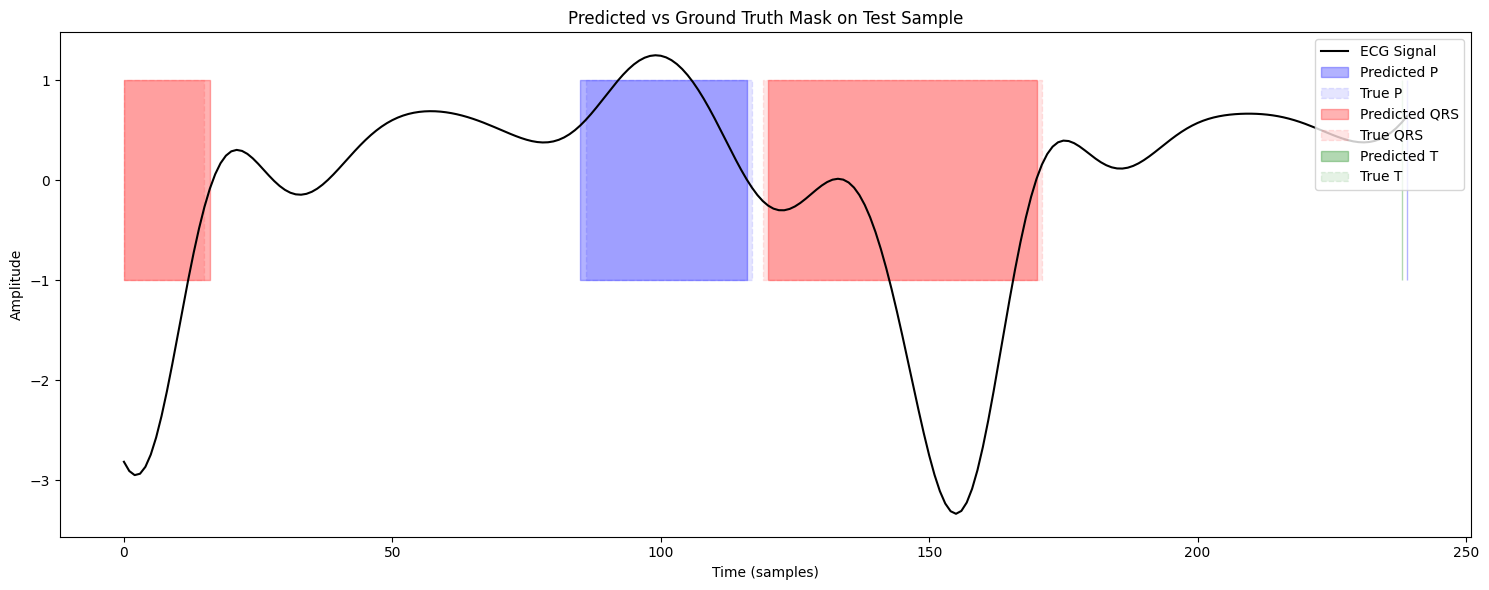

✅ Test Accuracy: 93.21%


In [29]:
test(model, test_loader)


In [30]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Final project/unet1d_ecg_qrs.pth")


In [32]:
model = UNet1D(n_classes=4)
model.load_state_dict(torch.load("/content/drive/MyDrive/Final project/unet1d_ecg_qrs.pth", map_location=device))
model.to(device)
model.eval()


UNet1D(
  (enc1): ConvBlock1D(
    (block): Sequential(
      (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): ConvBlock1D(
    (block): Sequential(
      (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool2): MaxPool

In [33]:
def predict_full_ecg(signal, model, fs=250, window_size=240):
    model.eval()
    signal = signal[:len(signal) - (len(signal) % window_size)]  # crop to multiple of window_size
    signal = normalize_signal(smooth_signal(bandpass_filter(signal, fs=fs)))
    signal = signal.reshape(1, 1, -1)  # (1, 1, L)

    segments = []
    for i in range(0, signal.shape[2] - window_size + 1, window_size):
        window = signal[:, :, i:i+window_size]
        segments.append(window)

    predictions = []
    with torch.no_grad():
        for window in segments:
            window = torch.tensor(window, dtype=torch.float32).to(device)
            output = model(window)  # (1, C, L)
            pred = torch.argmax(output, dim=1).cpu().numpy()[0]  # (L,)
            predictions.append(pred)

    full_prediction = np.concatenate(predictions)
    return full_prediction


In [38]:
def get_wave_boundaries(predicted_labels):
    wave_types = {1: 'P', 2: 'QRS', 3: 'T'}
    wave_boundaries = {k: [] for k in wave_types.values()}

    current_class = None
    start = None

    for i, label in enumerate(predicted_labels):
        if label in wave_types:
            if current_class is None:
                current_class = label
                start = i
            elif label != current_class:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = label
                start = i
        else:

            if current_class is not None:
                wave_boundaries[wave_types[current_class]].append((start, i-1))
                current_class = None
                start = None

    # Handle last segment
    if current_class is not None:
        wave_boundaries[wave_types[current_class]].append((start, len(predicted_labels)-1))

    return wave_boundaries


In [39]:
def visualize_boundaries(signal, boundaries, fs=250, zoom=(0, None)):
    time = np.arange(len(signal)) / fs  # in seconds

    plt.figure(figsize=(18, 6))
    plt.plot(time, signal, color='black', label='ECG Signal', linewidth=1)

    wave_colors = {'P': 'blue', 'QRS': 'red', 'T': 'green'}

    for wave_type, regions in boundaries.items():
        for start, end in regions:
            plt.fill_between(
                time[start:end],
                -1, 1,
                color=wave_colors.get(wave_type, 'gray'),
                alpha=0.3,
                label=f'Predicted {wave_type}'
            )

    # Prevent duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.title("ECG Signal with Predicted Wave Regions", fontsize=16)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.tight_layout()

    # Optional zoom
    if zoom[1] is None:
        plt.xlim(zoom[0], time[-1])
    else:
        plt.xlim(zoom)

    plt.show()


In [40]:
# Load your test signal (e.g., from wfdb)
record = wfdb.rdrecord('/content/drive/MyDrive/Final project/dataset/physionet.org/files/mitdb/1.0.0/101')
signal = record.p_signal[:, 0]  # lead I

# Predict
pred_labels = predict_full_ecg(signal, model, fs=250)

# Extract wave start/end
boundaries = get_wave_boundaries(pred_labels)
print(boundaries)


{'P': [(22, 47), (333, 362), (648, 674), (968, 997), (1303, 1330), (1645, 1672), (1973, 1996), (2287, 2320), (2600, 2626), (2911, 2938), (3235, 3262), (3567, 3590), (3896, 3925), (4221, 4248), (4545, 4575), (4866, 4893), (5176, 5201), (5504, 5530), (5831, 5861), (6157, 6186), (6465, 6499), (6770, 6799), (7079, 7107), (7398, 7426), (7722, 7750), (8042, 8070), (8348, 8378), (8659, 8689), (8962, 8992), (9257, 9288), (9563, 9591), (9887, 9914), (10219, 10242), (10532, 10551), (10831, 10859), (11124, 11155), (11410, 11431), (11694, 11722), (11982, 12012), (12267, 12272), (12276, 12298), (12557, 12586), (12845, 12876), (13121, 13151), (13397, 13424), (13677, 13705), (13971, 13997), (14267, 14295), (14575, 14604), (14864, 14887), (15135, 15163), (15411, 15439), (15699, 15727), (15988, 16014), (16285, 16311), (16590, 16617), (16892, 16920), (17187, 17214), (17473, 17500), (17754, 17783), (18037, 18065), (18330, 18360), (18622, 18652), (18916, 18944), (19204, 19235), (19500, 19527), (19797, 198

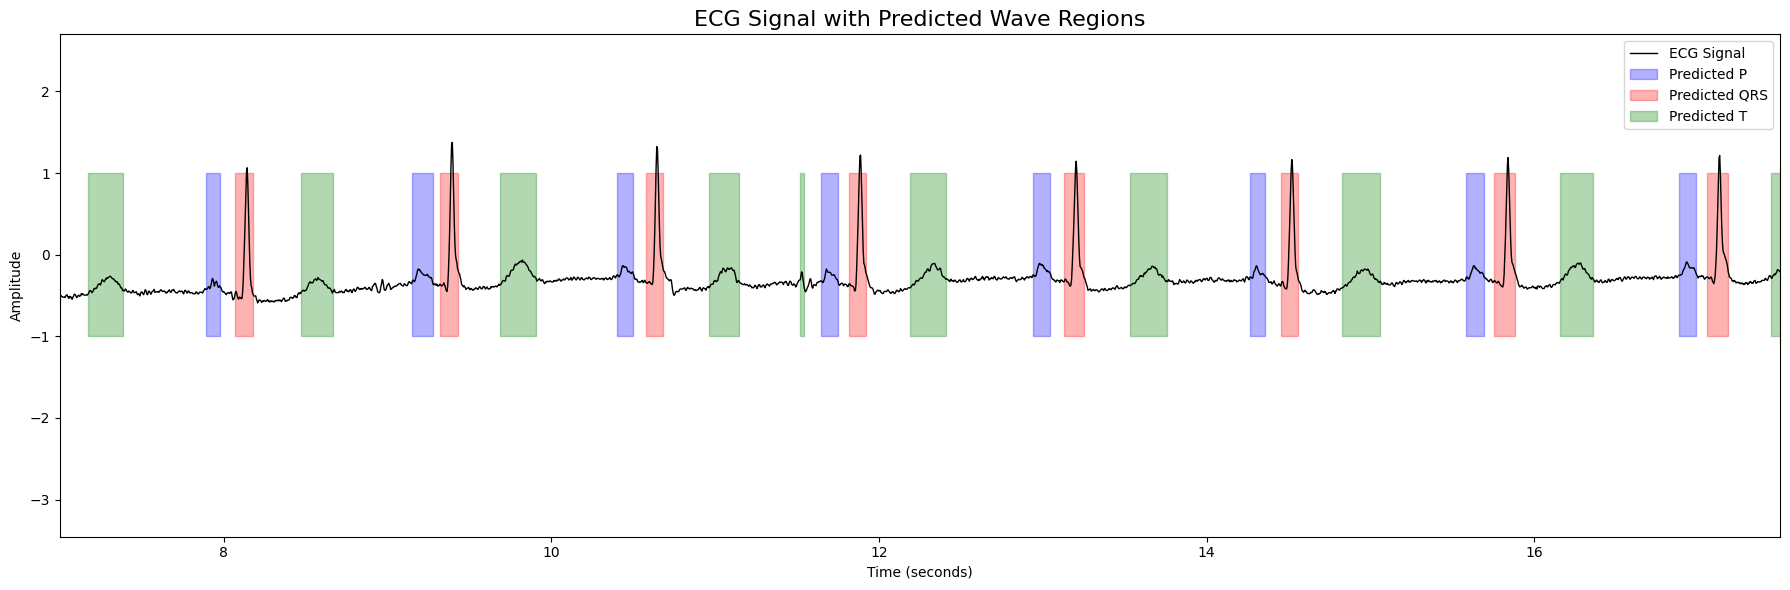

In [41]:
visualize_boundaries(signal, boundaries, fs=250, zoom=(7, 17.5))
